In [44]:
%load_ext autoreload

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
sys.path.append("../scripts/")  # Add the scripts folder to the path
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from data_preprocessing import clean_data, handle_outliers
from visualizations import visualize_clusters
from data_transform import convert_bytes_to_mb, rename_columns
from experience_analytics import aggregate_customer_data
from engagement_metrics import calculate_engagement_metrics
from data_export import export_to_postgresql
from satisfaction_analysis import (
    calculate_scores,
    calculate_satisfaction,
    build_regression_model,
    run_kmeans,
    aggregate_scores_per_cluster,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
%autoreload 2

In [6]:
# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [7]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [8]:
telecom_data = clean_data(df)
print(telecom_data.info())
print(telecom_data.isnull().sum())  
print(telecom_data.shape)         


<class 'pandas.core.frame.DataFrame'>
Index: 148488 entries, 0 to 149999
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Bearer Id                       148488 non-null  object        
 1   Start                           148488 non-null  datetime64[ns]
 2   Start ms                        148488 non-null  float64       
 3   End                             148488 non-null  datetime64[ns]
 4   End ms                          148488 non-null  float64       
 5   IMSI                            148488 non-null  object        
 6   MSISDN/Number                   148488 non-null  object        
 7   IMEI                            148488 non-null  object        
 8   Last Location Name              148488 non-null  category      
 9   Avg RTT DL (ms)                 148488 non-null  float64       
 10  Avg RTT UL (ms)                 148488 non-null  float64     

In [9]:
# Select numeric columns
numeric_columns = telecom_data.select_dtypes(include=['float64', 'int64']).columns

# Treat outliers using the handle_outliers function
telecom_data = handle_outliers(telecom_data, numeric_columns)


In [10]:
# Define the renaming dictionary
rename_dict = {'Dur. (ms).1': 'Dur. (ms)'}

# Rename columns using the rename_columns function
telecom_data = rename_columns(telecom_data, rename_dict)

# Verify the column names
print(telecom_data.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms)',
       'Handset Manufacturer', 'Handset Type', 'Nb of sec with Vol DL < 6250B',
       'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming 

In [19]:
# Load your engagement and experience data
#engagement_data = pd.read_csv('engagement_data.csv')  # Replace with your engagement data file
#experience_data = pd.read_csv('experience_data.csv')  # Replace with your experience data file
experience_data = aggregate_customer_data(telecom_data)
print("Experience data:")
print(experience_data.head())
engagement_data = calculate_engagement_metrics(telecom_data)
print("\n\nEngagement data:")
print(engagement_data.head())

Experience data:
   MSISDN/Number  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  \
0   3.360100e+10                 2.081339e+07                759850.598148   
1   3.360100e+10                 2.081339e+07                759850.598148   
2   3.360100e+10                 2.081339e+07                759850.598148   
3   3.360101e+10                 1.066000e+03                759850.598148   
4   3.360101e+10                 1.508151e+07                390526.299074   

   Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0        46.000000         0.000000                     37.0   
1        30.000000         1.000000                     48.0   
2       109.796253        17.662883                     48.0   
3        69.000000        15.000000                    204.0   
4        57.000000         2.500000                  20197.5   

   Avg Bearer TP UL (kbps)                    Handset Type  
0                     39.0  Huawei P20 Lite Huawei Nova 3E  
1      

In [23]:
print("Engagement Data Columns:")
print(engagement_data.columns)

print("Experience Data Columns:")
print(experience_data.columns)

Engagement Data Columns:
Index(['MSISDN/Number', 'session_frequency', 'session_duration',
       'total_download_traffic', 'total_upload_traffic', 'total_traffic'],
      dtype='object')
Experience Data Columns:
Index(['MSISDN/Number', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
       'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'Handset Type'],
      dtype='object')


In [25]:
# Calculate engagement and experience scores
scores = calculate_scores(engagement_data, experience_data)
print("Engagement and Experience Scores:")
print(scores.head())

Engagement and Experience Scores:
   MSISDN/Number  Engagement Score  Experience Score
0   3.360100e+10      1.192946e+09      7.016015e+07
1   3.360100e+10      2.433492e+08      7.016015e+07
2   3.360100e+10      7.965168e+08      7.016015e+07
3   3.360101e+10      5.550563e+08      9.097246e+07
4   3.360101e+10      1.967646e+09      7.589200e+07


In [36]:
# Calculate satisfaction scores
top_satisfied = calculate_satisfaction(scores)
print("Top 10 Satisfied Customers:")
print(top_satisfied)
print(scores)

Top 10 Satisfied Customers:
       MSISDN/Number  Engagement Score  Experience Score  Satisfaction Score  \
92581   3.376054e+10      1.187450e+10      7.481015e+07        5.974657e+09   
13123   3.362578e+10      1.175064e+10      7.626407e+07        5.913454e+09   
6404    3.361489e+10      1.169197e+10      8.343218e+07        5.887703e+09   
13467   3.362632e+10      1.116705e+10      7.823522e+07        5.622640e+09   
76074   3.367588e+10      1.116056e+10      8.030525e+07        5.620432e+09   
36907   3.365973e+10      1.106836e+10      8.575696e+07        5.577059e+09   
62802   3.366646e+10      1.024791e+10      7.954727e+07        5.163727e+09   
57030   3.366471e+10      9.258001e+09      8.109575e+07        4.669548e+09   
86135   3.369879e+10      9.054758e+09      7.839702e+07        4.566578e+09   
30590   3.365836e+10      8.913998e+09      7.803661e+07        4.496018e+09   

       Cluster  
92581        0  
13123        0  
6404         0  
13467        0  
76074 

In [27]:
# Build regression model to predict satisfaction score
model, X_test, y_test = build_regression_model(scores)
print("Regression Model Coefficients:")
print(model.coef_)

Regression Model Coefficients:
[0.5 0.5]


Cluster Centers:
[[2.14520946e+09 7.69646927e+07]
 [7.05985915e+08 7.63005715e+07]]
Clustered Data:
   MSISDN/Number  Cluster
0   3.360100e+10        1
1   3.360100e+10        1
2   3.360100e+10        1
3   3.360101e+10        1
4   3.360101e+10        0


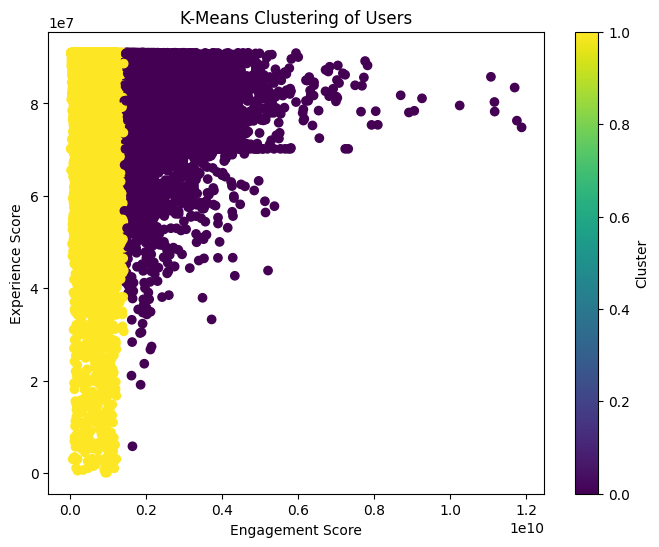

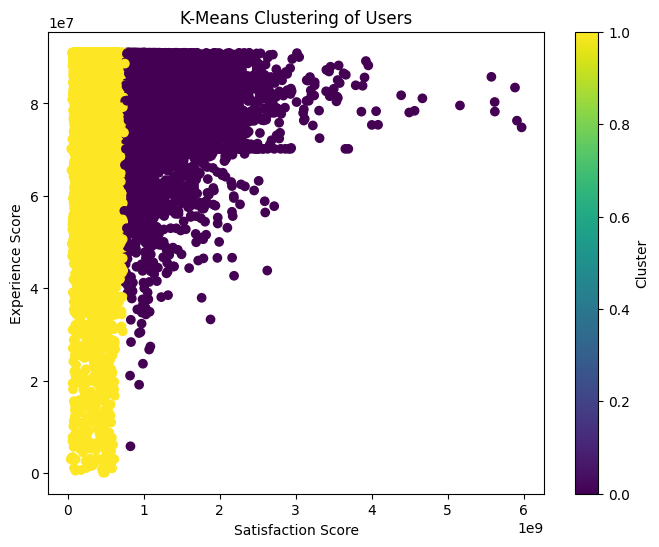

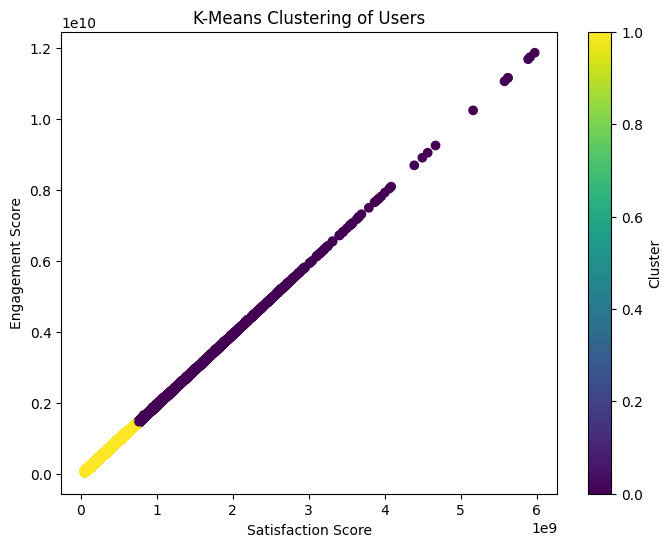

In [35]:
# Run K-Means on engagement and experience scores
clustered_scores, cluster_centers = run_kmeans(scores)
print("Cluster Centers:")
print(cluster_centers)
print("Clustered Data:")
print(clustered_scores[['MSISDN/Number', 'Cluster']].head())

visualize_clusters(scores, 'Engagement Score', 'Experience Score')
visualize_clusters(scores, 'Satisfaction Score', 'Experience Score')
visualize_clusters(scores, 'Satisfaction Score', 'Engagement Score')

In [32]:
# Aggregate average scores per cluster
aggregated_scores = aggregate_scores_per_cluster(clustered_scores)
print("Aggregated Scores per Cluster:")
print(aggregated_scores)

Aggregated Scores per Cluster:
   Cluster  Satisfaction Score  Engagement Score  Experience Score
0        0        1.111705e+09      2.146445e+09      7.696574e+07
1        1        3.912502e+08      7.061998e+08      7.630059e+07


In [47]:
# Export to MySQL database
export_to_postgresql(clustered_scores)

Data exported to PostgreSQL database.
